# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import os
import sys

import mujoco
import mediapy as media
from gym import Env
from gym.spaces import Discrete, Box

import stable_baselines3
from stable_baselines3.common.env_checker import check_env
import torch as th
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure
from stable_baselines3.common.logger import Logger, CSVOutputFormat, HumanOutputFormat

# Cargar los datos de captura de movimiento y simulación

In [2]:
datos = pd.read_csv('datos_seguimiento_3_polyfit15_conpos_g1.csv',sep=",")
array_datos = datos.to_numpy() #guarda los datos del csv cargado como arreglo de numpy

with open("g1_29dof_position_bloqueadoaire2.xml", "r", encoding="utf-8") as f:
    xml = f.read() #Leer el archivo de mujoco cargado al entorno de ejecución y lo guarda en la variable xml

""

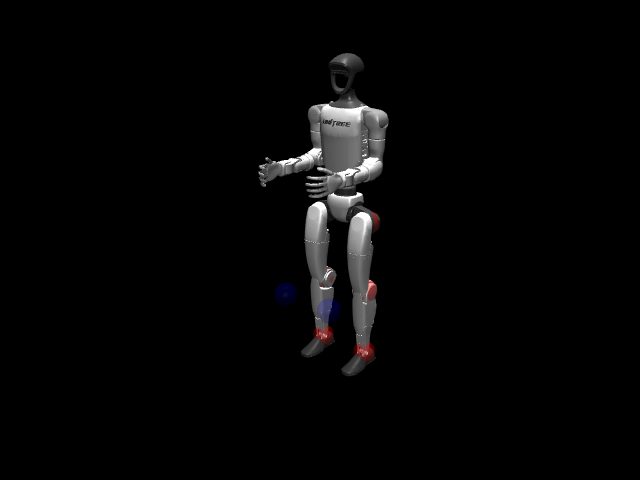

In [3]:
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
height = 480
width = 640

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [4]:
# Make renderer, render and show the pixels
height = 480
width = 640
duration = 5  # (seconds)
framerate = 24  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.

with mujoco.Renderer(model, height, width) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

In [5]:
print("detected geoms:")
try:
  model.geom()
except KeyError as e:
  print(e)

#data = mujoco.MjData(model)
print("data object:")
print(data)

print("detected actuators:")
try:
  model.actuator()
except KeyError as e:
  print(e)

print("detected sensors:")
try:
  model.sensor()
except KeyError as e:
  print(e)


print("detected joints:")
try:
  model.joint()
except KeyError as e:
  print(e)

detected geoms:
"Invalid name ''. Valid names: ['left_ankle_pitch_link_tracker', 'left_hip_pitch_link_tracker', 'left_knee_link_align_tracker', 'left_knee_link_tracker', 'right_ankle_pitch_link_tracker', 'right_hip_pitch_link_tracker', 'right_knee_link_align_tracker', 'right_knee_link_tracker']"
data object:
detected actuators:
"Invalid name ''. Valid names: ['left_ankle_pitch_joint', 'left_ankle_roll_joint', 'left_hip_pitch_joint', 'left_hip_roll_joint', 'left_hip_yaw_joint', 'left_knee_joint', 'right_ankle_pitch_joint', 'right_ankle_roll_joint', 'right_hip_pitch_joint', 'right_hip_roll_joint', 'right_hip_yaw_joint', 'right_knee_joint']"
detected sensors:
"Invalid name ''. Valid names: ['imu-pelvis-angular-velocity', 'imu-pelvis-linear-acceleration', 'imu-torso-angular-velocity', 'imu-torso-linear-acceleration']"
detected joints:
"Invalid name ''. Valid names: ['left_ankle_pitch_joint', 'left_ankle_roll_joint', 'left_hip_pitch_joint', 'left_hip_roll_joint', 'left_hip_yaw_joint', 'left

In [6]:
print(data.geom('left_hip_pitch_link_tracker').xpos)

[-5.88612807e-04  1.16452000e-01  6.59840687e-01]


In [7]:
data.actuator("left_knee_joint").ctrl=0.1
print(data.actuator("left_knee_joint").ctrl)

[0.1]


In [8]:
print(data.joint("left_knee_joint"))
print(data.joint("left_knee_joint").qpos)

<_MjDataJointViews
  cdof: array([[ 0.03134855,  0.        , -0.01720543,  0.98792216,  0.        ,
         0.15495098]])
  cdof_dot: array([[ 0.        ,  0.        ,  0.        ,  0.02060313,  0.        ,
        -0.13135957]])
  id: 3
  name: 'left_knee_joint'
  qLDiagInv: array([11.34601861])
  qacc: array([0.0696286])
  qacc_smooth: array([0.0696286])
  qacc_warmstart: array([0.0696286])
  qfrc_actuator: array([-0.14213605])
  qfrc_applied: array([0.])
  qfrc_bias: array([-0.15431064])
  qfrc_constraint: array([0.])
  qfrc_inverse: array([0.])
  qfrc_passive: array([0.])
  qfrc_smooth: array([0.01217458])
  qpos: array([0.00358649])
  qvel: array([0.04388004])
  xanchor: array([-0.00650589,  0.11889406,  0.35376932])
  xaxis: array([-8.78006585e-05,  9.99999541e-01,  9.54503201e-04])
>
[0.00358649]


In [9]:
# Make renderer, render and show the pixels
height = 480
width = 640
duration = 2  # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.

with mujoco.Renderer(model, height, width) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    data.actuator("left_knee_joint").ctrl+=0.025
    #if(data.actuator("left_knee_joint").ctrl>1):
    #  data.actuator("left_knee_joint").ctrl=1
    #print(data.actuator("left_knee_joint").ctrl)
    #print(data.joint("left_knee_joint").qpos)
    #print(data.geom('left_hip_pitch_link_tracker').xpos)
    
    #print(data.geom('left_knee_link_tracker').xpos)
    
    
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

# Ambiente de Gym

In [10]:
class RobotBipedoG1(Env):
  def __init__(self, xml_text, tracking_array, tiempo_max_sim, tracking_fps=30):

    #Algunos parámetros asociados a la física del robot y la simulación de MuJoCo
    self.simulation_time_step=0.002 #La simulación corre en pasos de 0.002 segundos (frecuencia de 500 Hz)
    self.max_step_motors=0.003 #Delta de Posición


    #Se crea la simulación con el xml cargado
    # Make model and data
    self.model = mujoco.MjModel.from_xml_string(xml_text)
    self.data = mujoco.MjData(self.model)


    # El estado es definido por 8 valores
    # Orden: 
    # 0 Angulo Cadera-Rodilla pierna 1
    # 1 Angulo Rodilla-Tobillo pierna 1
    # 2 Angulo Cadera-Tobillo pierna 1
    # 3 Angulo Cadera-Rodilla pierna 2 
    # 4 Angulo Rodilla-Tobillo pierna 2
    # 5 Angulo Cadera-Tobillo pierna 2
    # 6 tiempo
    self.observation_space = Box(low=-np.inf, high=np.inf, shape=(19, ))

    # Las acciones son definidas como un continuo en cada paso de la simulación. Limitado por el paso de la simulación y velocidad motores
    # Orden: 
    # 0 right_hip_pitch_joint
    # 1 right_hip_roll_joint
    # 2 right_hip_yaw_joint
    # 3 right_knee_joint 
    # 4 right_ankle_pitch_joint
    # 5 right_ankle_roll_joint
    # 6 left_hip_pitch_joint
    # 7 left_hip_roll_joint
    # 8 left_hip_yaw_joint
    # 9 left_knee_joint 
    # 10 left_ankle_pitch_joint
    # 11 left_ankle_roll_joint
    # 12 waist_pitch_joint
    self.action_space = Box(low=-1, high=1, shape=(12,))

    #El estado inicial está dado por el tracking inicial
    # 0  Cadera pierna 1 x
    # 1  Cadera pierna 1 y
    # 2  Cadera pierna 1 z
    # 3  Rodilla pierna 1 x
    # 4  Rodilla pierna 1 y
    # 5  Rodilla pierna 1 z
    # 6  Tobillo pierna 1 x
    # 7  Tobillo pierna 1 y
    # 8  Tobillo pierna 1 z
    # 9  Cadera pierna 2 x
    # 10 Cadera pierna 2 y
    # 11 Cadera pierna 2 z
    # 12 Rodilla pierna 2 x
    # 13 Rodilla pierna 2 y
    # 14 Rodilla pierna 2 z
    # 15 Tobillo pierna 2 x
    # 16 Tobillo pierna 2 y
    # 17 Tobillo pierna 2 z
    # 18 tiempo
    self.state=np.concatenate((self.data.geom('right_hip_pitch_link_tracker').xpos,
                              self.data.geom('right_knee_link_tracker').xpos,
                              self.data.geom('right_ankle_pitch_link_tracker').xpos,
                              self.data.geom('left_hip_pitch_link_tracker').xpos,
                              self.data.geom('left_knee_link_tracker').xpos,
                              self.data.geom('left_ankle_pitch_link_tracker').xpos,
                              np.array([self.data.time])))
    

    #Se configura un tiempo final de simulación
    if(tiempo_max_sim<=4.9):
      self.final_simulation_time=tiempo_max_sim
    else:
      self.final_simulation_time=4.9  #la simulación se termina en 5 segundos

    #Se almacena la secuencia de tracking de movimiento a seguir
    #Orden por columnas: Número de frame a X Hz, Ángulo cadera-rodilla_p1, Ángulo rodilla-tobillo_p1, Ángulo cadera-tobillo_p1, Ángulo cadera-rodilla_p2, Ángulo rodilla-tobillo_p2, Ángulo cadera-tobillo_p2 
    self.framerate=tracking_fps
    self.tracking=tracking_array

    #Crea una lista vacía para guardar frames de simulación (60 Hz) y otras opciones
    self.height=480
    self.width=640
    self.frames=[]
    self.renderer = mujoco.Renderer(self.model, self.height, self.width)

    #Inicializa el primer objetivo
    self.obj_frame=1
    self.objective_pos=self.tracking[self.obj_frame-1][7]

  def map_action(self, action_normalized):
    if action_normalized<-0.5:
      return -self.max_step_motors
    elif action_normalized>0.5:
      return self.max_step_motors
    else:
      return 0.000

  #Función donde se accionan los controladores, según la acción y los límites
  def actuate_model(self, action):
    #Añade a los controladores los ángulos del vector de acciones
    self.data.actuator("right_hip_pitch_joint").ctrl+= self.map_action(action[0])
    self.data.actuator("right_hip_roll_joint").ctrl+= self.map_action(action[1])
    self.data.actuator("right_hip_yaw_joint").ctrl+= self.map_action(action[2])
    self.data.actuator("right_knee_joint").ctrl+= self.map_action(action[3])
    self.data.actuator("right_ankle_pitch_joint").ctrl+= self.map_action(action[4])
    self.data.actuator("right_ankle_roll_joint").ctrl+= self.map_action(action[5])
    self.data.actuator("left_hip_pitch_joint").ctrl+= self.map_action(action[6])
    self.data.actuator("left_hip_roll_joint").ctrl+= self.map_action(action[7])
    self.data.actuator("left_hip_yaw_joint").ctrl+= self.map_action(action[8])
    self.data.actuator("left_knee_joint").ctrl+= self.map_action(action[9])
    self.data.actuator("left_ankle_pitch_joint").ctrl+= self.map_action(action[10])
    self.data.actuator("left_ankle_roll_joint").ctrl+= self.map_action(action[11])
    """
    self.data.actuator("right_hip_pitch_joint").ctrl+=np.clip(action[0],-self.max_step_motors,self.max_step_motors)
    self.data.actuator("right_hip_roll_joint").ctrl+=np.clip(action[1],-self.max_step_motors,self.max_step_motors)
    self.data.actuator("right_hip_yaw_joint").ctrl+=np.clip(action[2],-self.max_step_motors,self.max_step_motors)
    self.data.actuator("right_knee_joint").ctrl+=np.clip(action[3],-self.max_step_motors,self.max_step_motors)
    self.data.actuator("right_ankle_pitch_joint").ctrl+=np.clip(action[4],-self.max_step_motors,self.max_step_motors)
    self.data.actuator("right_ankle_roll_joint").ctrl+=np.clip(action[5],-self.max_step_motors,self.max_step_motors)
    self.data.actuator("left_hip_pitch_joint").ctrl+=np.clip(action[6],-self.max_step_motors,self.max_step_motors)
    self.data.actuator("left_hip_roll_joint").ctrl+=np.clip(action[7],-self.max_step_motors,self.max_step_motors)
    self.data.actuator("left_hip_yaw_joint").ctrl+=np.clip(action[8],-self.max_step_motors,self.max_step_motors)
    self.data.actuator("left_knee_joint").ctrl+=np.clip(action[9],-self.max_step_motors,self.max_step_motors)
    self.data.actuator("left_ankle_pitch_joint").ctrl+=np.clip(action[10],-self.max_step_motors,self.max_step_motors)
    self.data.actuator("left_ankle_roll_joint").ctrl+=np.clip(action[11],-self.max_step_motors,self.max_step_motors)"""
    #self.data.actuator("waist_pitch_joint").ctrl+=np.clip(action[12],-self.max_step_motors,self.max_step_motors)
    
    """self.data.actuator("arnes1").ctrl=self.objective_pos+0.05
    self.data.actuator("arnes2").ctrl=self.objective_pos+0.05
    self.data.actuator("arnes3").ctrl=self.objective_pos+0.05"""
    #Usa clip para aplicar los límites superiores e inferiores
    self.data.actuator("right_hip_pitch_joint").ctrl=np.clip(self.data.actuator("right_hip_pitch_joint").ctrl,-2.5307,2.8798)
    self.data.actuator("right_hip_roll_joint").ctrl=np.clip(self.data.actuator("right_hip_roll_joint").ctrl,-0.5236,2.9671)
    self.data.actuator("right_hip_yaw_joint").ctrl=np.clip(self.data.actuator("right_hip_yaw_joint").ctrl,-2.7576,2.7576)
    self.data.actuator("right_knee_joint").ctrl=np.clip(self.data.actuator("right_knee_joint").ctrl,-0.087267,2.8798)
    self.data.actuator("right_ankle_pitch_joint").ctrl=np.clip(self.data.actuator("right_ankle_pitch_joint").ctrl,-0.87267,0.5236)
    self.data.actuator("right_ankle_roll_joint").ctrl=np.clip(self.data.actuator("right_ankle_roll_joint").ctrl,-0.2618,0.2618)
    self.data.actuator("left_hip_pitch_joint").ctrl=np.clip(self.data.actuator("left_hip_pitch_joint").ctrl,-2.5307,2.8798)
    self.data.actuator("left_hip_roll_joint").ctrl=np.clip(self.data.actuator("left_hip_roll_joint").ctrl,-2.9671,0.5236)
    self.data.actuator("left_hip_yaw_joint").ctrl=np.clip(self.data.actuator("left_hip_yaw_joint").ctrl,-2.7576,2.7576)
    self.data.actuator("left_knee_joint").ctrl=np.clip(self.data.actuator("left_knee_joint").ctrl,-0.087267,2.8798)
    self.data.actuator("left_ankle_pitch_joint").ctrl=np.clip(self.data.actuator("left_ankle_pitch_joint").ctrl,-0.87267,0.5236)
    self.data.actuator("left_ankle_roll_joint").ctrl=np.clip(self.data.actuator("left_ankle_roll_joint").ctrl,-0.2618,0.2618)
    #self.data.actuator("waist_pitch_joint").ctrl=np.clip(self.data.actuator("waist_pitch_joint").ctrl,-0.52,0.52)

    """self.data.actuator("arnes1").ctrl=np.clip(self.data.actuator("arnes1").ctrl,-1,3)
    self.data.actuator("arnes2").ctrl=np.clip(self.data.actuator("arnes2").ctrl,-1,3)
    self.data.actuator("arnes3").ctrl=np.clip(self.data.actuator("arnes3").ctrl,-1,3)"""
    
  

  def step(self,action):

    #Ejecuta la acción y se cambian los controladores en la simulación
    self.actuate_model(action)
    #Da el paso de simulación
    mujoco.mj_step(self.model, self.data) #necesita dar un paso al inicio
    #Lee las nuevas posiciones (estado)

    

    self.state=np.concatenate((self.data.geom('right_hip_pitch_link_tracker').xpos,
                              self.data.geom('right_knee_link_tracker').xpos,
                              self.data.geom('right_ankle_pitch_link_tracker').xpos,
                              self.data.geom('left_hip_pitch_link_tracker').xpos,
                              self.data.geom('left_knee_link_tracker').xpos,
                              self.data.geom('left_ankle_pitch_link_tracker').xpos,
                              np.array([self.data.time])))
    
    current_angle_cadera_rodilla_pierna1=np.arctan(((self.state[3]-self.state[0]))/np.abs((self.state[5]-self.state[2])))
    current_angle_rodilla_tobillo_pierna1=np.arctan(((self.state[6]-self.state[3]))/np.abs((self.state[8]-self.state[5])))
    current_angle_cadera_tobillo_pierna1=np.arctan(((self.state[6]-self.state[0]))/np.abs((self.state[8]-self.state[2])))
    current_angle_cadera_rodilla_pierna2=np.arctan(((self.state[12]-self.state[9]))/np.abs((self.state[14]-self.state[11])))
    current_angle_rodilla_tobillo_pierna2=np.arctan(((self.state[15]-self.state[12]))/np.abs((self.state[17]-self.state[14])))
    current_angle_cadera_tobillo_pierna2=np.arctan(((self.state[15]-self.state[9]))/np.abs((self.state[17]-self.state[11])))
    current_pos=(self.state[0]+self.state[9])/2
    current_align_angle_rodilla_tobillo_pierna1=np.arctan(((self.state[7]-self.state[4]))/np.abs((self.state[8]-self.state[5])))
    current_align_angle_cadera_tobillo_pierna1=np.arctan(((self.state[7]-self.state[1]))/np.abs((self.state[8]-self.state[2])))
    current_align_angle_rodilla_pierna1=np.arctan(((self.data.geom('right_knee_link_align_tracker').xpos[1]-self.state[4]))/np.abs((self.data.geom('right_knee_link_align_tracker').xpos[0]-self.state[3])))
    current_align_angle_rodilla_tobillo_pierna2=np.arctan(((self.state[16]-self.state[13]))/np.abs((self.state[17]-self.state[14])))
    current_align_angle_cadera_tobillo_pierna2=np.arctan(((self.state[16]-self.state[10]))/np.abs((self.state[17]-self.state[11])))
    current_align_angle_rodilla_pierna2=np.arctan(((self.data.geom('left_knee_link_align_tracker').xpos[1]-self.state[13]))/np.abs((self.data.geom('left_knee_link_align_tracker').xpos[0]-self.state[12])))

    #Calcula una reward, tiempo de simulación y objetivo de tracking de movimiento en frame específico
    #revisa el tiempo actual de simulación, contraste con los objetivos de la captura de movimiento, y revisa los ángulos objetivo
    if(self.data.time > self.obj_frame/self.framerate):
      self.obj_frame+=1
    objective_angle_cadera_rodilla_pierna1=self.tracking[self.obj_frame-1][1]
    objective_angle_rodilla_tobillo_pierna1=self.tracking[self.obj_frame-1][2]
    objective_angle_cadera_tobillo_pierna1=self.tracking[self.obj_frame-1][3]
    objective_angle_cadera_rodilla_pierna2=self.tracking[self.obj_frame-1][4]
    objective_angle_rodilla_tobillo_pierna2=self.tracking[self.obj_frame-1][5]
    objective_angle_cadera_tobillo_pierna2=self.tracking[self.obj_frame-1][6]
    self.objective_pos=self.tracking[self.obj_frame-1][7] 
    objective_align_angle_rodilla_tobillo_pierna1=0
    objective_align_angle_cadera_tobillo_pierna1=0
    objective_align_angle_rodilla_pierna1=0
    objective_align_angle_rodilla_tobillo_pierna2=0
    objective_align_angle_cadera_tobillo_pierna2=0
    objective_align_angle_rodilla_pierna2=0

    

    #calcula reward
    rp=np.exp(-2*((objective_angle_cadera_rodilla_pierna1-current_angle_cadera_rodilla_pierna1)**2+(objective_angle_rodilla_tobillo_pierna1-current_angle_rodilla_tobillo_pierna1)**2+(objective_angle_cadera_rodilla_pierna2-current_angle_cadera_rodilla_pierna2)**2+(objective_angle_rodilla_tobillo_pierna2-current_angle_rodilla_tobillo_pierna2)**2+(objective_align_angle_rodilla_tobillo_pierna1-current_align_angle_rodilla_tobillo_pierna1)**2+(objective_align_angle_rodilla_tobillo_pierna2-current_align_angle_rodilla_tobillo_pierna2)**2+(objective_align_angle_rodilla_pierna1-current_align_angle_rodilla_pierna1)**2+(objective_align_angle_rodilla_pierna2-current_align_angle_rodilla_pierna2)**2))
    rv=0
    re=np.exp(-40*((objective_angle_cadera_tobillo_pierna1-current_angle_cadera_tobillo_pierna1)**2+(objective_angle_cadera_tobillo_pierna2-current_angle_cadera_tobillo_pierna2)**2+(objective_align_angle_cadera_tobillo_pierna1-current_align_angle_cadera_tobillo_pierna1)**2+(objective_align_angle_cadera_tobillo_pierna2-current_align_angle_cadera_tobillo_pierna2)**2))
    rc=np.exp(-10*((self.objective_pos-current_pos)**2))
    reward=0.65*rp+0.1*rv+0.15*re+0.1*rc

    #Condiciones de finalización
    #si pierde el equilibrio y se cae
    done=False
    if(self.state[2]<0.28 or self.state[11]<0.28):
      done=True
      reward=-80
    if(self.data.time >= self.final_simulation_time):
      done=True

    #Complementar
    info={
      "reward": reward,
      "state": self.state,
      "objective": self.tracking[self.obj_frame-1],
      "time": self.data.time
    }

    #Retornos
    return self.state, reward, done, info


  def render(self):
    #después de la función step(action) se llama a esta función, así que se comentan algunas líneas
    if len(self.frames) < self.data.time * self.framerate:
      self.renderer.update_scene(self.data)
      pixels = self.renderer.render()
      self.frames.append(pixels)

  def reset(self):
    self.frames=[] #borra los frames
    self.obj_frame=1 #reinicia el objetivo de tracking
    mujoco.mj_resetData(self.model, self.data) #reinicia la simulación
    
    self.state==np.concatenate((self.data.geom('right_hip_pitch_link_tracker').xpos,
                              self.data.geom('right_knee_link_tracker').xpos,
                              self.data.geom('right_ankle_pitch_link_tracker').xpos,
                              self.data.geom('left_hip_pitch_link_tracker').xpos,
                              self.data.geom('left_knee_link_tracker').xpos,
                              self.data.geom('left_ankle_pitch_link_tracker').xpos,
                              np.array([self.data.time])))
    
    self.objective_pos=self.tracking[self.obj_frame-1][7]

    return self.state


In [11]:
env=RobotBipedoG1(xml_text=xml, tracking_array=array_datos, tiempo_max_sim=2, tracking_fps=30)
#el ambiente es creado usando la variable xml donde se cargó la simulación y el arreglo con la captura de movimiento

In [12]:
env3=RobotBipedoG1(xml_text=xml, tracking_array=array_datos, tiempo_max_sim=2, tracking_fps=30)
#el ambiente es creado usando la variable xml donde se cargó la simulación y el arreglo con la captura de movimiento
state=env3.reset()
new_state=state
done=False
recompensa_acumulada=0
pasos=0

while not done:
  state=new_state
  pasos+=1
  action=np.array([1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1])
  new_state,reward,done,info=env3.step(action)
  print(env3.data.actuator("right_hip_pitch_joint").ctrl)
  recompensa_acumulada+=reward
  env3.render()

print("Recompensa total {} en {} pasos de tiempo.".format(recompensa_acumulada,pasos))
media.show_video(env3.frames, fps=env3.framerate)

[0.003]
[0.006]
[0.009]
[0.012]
[0.015]
[0.018]
[0.021]
[0.024]
[0.027]
[0.03]
[0.033]
[0.036]
[0.039]
[0.042]
[0.045]
[0.048]
[0.051]
[0.054]
[0.057]
[0.06]
[0.063]
[0.066]
[0.069]
[0.072]
[0.075]
[0.078]
[0.081]
[0.084]
[0.087]
[0.09]
[0.093]
[0.096]
[0.099]
[0.102]
[0.105]
[0.108]
[0.111]
[0.114]
[0.117]
[0.12]
[0.123]
[0.126]
[0.129]
[0.132]
[0.135]
[0.138]
[0.141]
[0.144]
[0.147]
[0.15]
[0.153]
[0.156]
[0.159]
[0.162]
[0.165]
[0.168]
[0.171]
[0.174]
[0.177]
[0.18]
[0.183]
[0.186]
[0.189]
[0.192]
[0.195]
[0.198]
[0.201]
[0.204]
[0.207]
[0.21]
[0.213]
[0.216]
[0.219]
[0.222]
[0.225]
[0.228]
[0.231]
[0.234]
[0.237]
[0.24]
[0.243]
[0.246]
[0.249]
[0.252]
[0.255]
[0.258]
[0.261]
[0.264]
[0.267]
[0.27]
[0.273]
[0.276]
[0.279]
[0.282]
[0.285]
[0.288]
[0.291]
[0.294]
[0.297]
[0.3]
[0.303]
[0.306]
[0.309]
[0.312]
[0.315]
[0.318]
[0.321]
[0.324]
[0.327]
[0.33]
[0.333]
[0.336]
[0.339]
[0.342]
[0.345]
[0.348]
[0.351]
[0.354]
[0.357]
[0.36]
[0.363]
[0.366]
[0.369]
[0.372]
[0.375]
[0.378]
[0.38

In [13]:
policy_kwargs = dict(activation_fn=th.nn.ReLU,net_arch=dict(pi=[1024,512,256,128], vf=[1024,512,256,128]))
model = PPO(
        "MlpPolicy", env,
        learning_rate=0.0001,
        n_steps=4096,
        batch_size=1024,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.99,
        clip_range=0.15,
        ent_coef=0.0025,
        policy_kwargs=policy_kwargs,
        verbose=0
    )

/home/unitreeg1/santisolano/venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/unitreeg1/santisolano/venv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [14]:
# Crear el nombre del archivo CSV con timestamp
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
csv_path = f"./logs/ppo_m16_{timestamp}.csv"

# Crear un nuevo logger con CSV 
new_logger = Logger(
    folder="./logs/",
    output_formats=[
        CSVOutputFormat(csv_path)
    ]
)

# Asignar el nuevo logger al modelo
model.set_logger(new_logger)

model.learn(total_timesteps=10_000_000, progress_bar=True)

Output()

In [15]:
model.save(f"ppo_m16_{timestamp}")
print(f"modelo guardado como ppo_m16_{timestamp}")

modelo guardado como ppo_m16_2025-05-16_09-05


In [16]:
eval_env=RobotBipedoG1(xml_text=xml, tracking_array=array_datos, tiempo_max_sim=2)
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=5)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/home/unitreeg1/santisolano/venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/unitreeg1/santisolano/venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:498.74 +/- 0.15


In [17]:
episodios=1
for i in range(0,episodios):
  state=eval_env.reset()
  new_state=state
  done=False
  recompensa_acumulada=0
  pasos=0

  while not done:
    state=new_state
    pasos+=1
    action, _states = model.predict(state, deterministic=True)
    new_state,reward,done,info=eval_env.step(action)
    recompensa_acumulada+=reward
  print("Episodio {}: Recompensa total {} en {} pasos de tiempo.".format(i+1,recompensa_acumulada,pasos))

Episodio 1: Recompensa total 498.6608734758513 en 1000 pasos de tiempo.


In [18]:
state=eval_env.reset()
new_state=state
done=False
recompensa_acumulada=0
pasos=0

while not done:
  state=new_state
  pasos+=1
  action, _states = model.predict(state, deterministic=True)
  #print(action)
  new_state,reward,done,info=eval_env.step(action)
  print(new_state[1])
  recompensa_acumulada+=reward
  print(reward)
  eval_env.render()

print("Recompensa total {} en {} pasos de tiempo.".format(recompensa_acumulada,pasos))
media.show_video(eval_env.frames, fps=eval_env.framerate)

-0.116452
0.7837170541164865
-0.11645199999999999
0.7836902257612567
-0.116452
0.783666020595051
-0.116452
0.7836472316728931
-0.116452
0.7836356828095463
-0.116452
0.7836358718197313
-0.116452
0.7836550577344501
-0.116452
0.7837025965198777
-0.116452
0.7837890778699058
-0.11645199999999999
0.783925783429544
-0.116452
0.7841246788826349
-0.116452
0.7843985888487833
-0.11645199999999999
0.7847610768233654
-0.11645199999999999
0.7852258622356459
-0.116452
0.7858059182403733
-0.116452
0.7865125100396233
-0.116452
0.7684748024305728
-0.116452
0.7694680737100995
-0.11645199999999999
0.7705942168376206
-0.116452
0.7718533681121054
-0.116452
0.7732437607634344
-0.116452
0.7747619681806011
-0.11645199999999999
0.776403151176117
-0.116452
0.7781613190721167
-0.116452
0.7800296064731693
-0.11645199999999999
0.782000548212107
-0.116452
0.7840663203193362
-0.11645199999999999
0.7862189141480548
-0.11645199999999999
0.7884502240578267
-0.116452
0.79075204883781
-0.116452
0.7931160242867163
-0.11645